In [1]:
# Torch version
!python -c "import torch; print(torch.__version__)"

# Cuda version
!python -c "import torch; print(torch.version.cuda)"

2.6.0+cu124
12.4


In [2]:
# Uninstall
# !pip uninstall torch-scatter torch-sparse torch-cluster torch-spline-conv pyg-lib -y

In [3]:
# Update Torch
# !pip install torch==2.6.0 torchvision==0.21.0 torchaudio==2.6.0 --index-url https://download.pytorch.org/whl/cu124

In [4]:
# Install PyG (automatic)
# !pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-{torch.__version__}.html
# !pip install torch_geometric

In [5]:
# Verify instalation
import torch
import torch_geometric
import torch_scatter

print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())
print(torch_scatter.__version__)
print(torch_geometric.__version__)

/home/ealvarez/miniconda3/envs/graph_matching/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2.6.0+cu124
12.4
True
2.1.2+pt26cu124
2.7.0


In [6]:
from model_PyG import *
from utils import *

In [7]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch_geometric.transforms as T
import os
import umap

from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from torch_geometric.data import InMemoryDataset, Data
from torch_geometric.utils import dense_to_sparse, negative_sampling
from torch.nn.functional import binary_cross_entropy_with_logits
from torch.optim import Adam

In [8]:
import torch_geometric
print(torch_geometric.__version__)

2.7.0


### Utils

In [9]:
def info(data):
    print("Validate:\t {}".format(data.validate(raise_on_error=True)))
    print("Num. nodes:\t {}".format(data.num_nodes))
    print("Num. edges:\t {}".format(data.num_edges))
    print("Num. features:\t {}".format(data.num_node_features))
    print("Has isolated:\t {}".format(data.has_isolated_nodes()))
    print("Has loops:\t {}".format(data.has_self_loops()))
    print("Is directed:\t {}".format(data.is_directed()))
    print("Is undirected:\t {}".format(data.is_undirected()))
    print("{}".format(data.edge_index))
    print("{}".format(data.x))
    print("{}".format(data.edge_attr))

def compute_num_neg_samples(edge_index, num_nodes, ratio):
    E = edge_index.size(1)
    max_neg = num_nodes * num_nodes - E
    return min(int(ratio * E), max_neg)

def neg_ratio_schedule(epoch, max_epoch):
    start = 5.0
    end = 1.0
    return start - (start - end) * (epoch / max_epoch)

class EarlyStopping:
    def __init__(self, patience=5, delta=0, warmup=5, verbose=False):
        self.patience = patience
        self.delta = delta
        self.warmup = warmup
        self.verbose = verbose
        self.best_loss = None
        self.no_improvement_count = 0
        self.stop_training = False
    
    def check_early_stop(self, loss, epoch):
        if epoch >= self.warmup:
            if self.best_loss is None or loss < self.best_loss - self.delta:
                self.best_loss = loss
                self.no_improvement_count = 0
            else:
                self.no_improvement_count += 1
                if self.no_improvement_count >= self.patience:
                    self.stop_training = True
                    if self.verbose:
                        print("Stopping early as no improvement has been observed.")

### Parameters

In [ ]:
file = open("exp.json")
experiment = json.load(file)
exp = experiment["exp"] # Change to static

file = open("experiments/output/{}/parameters.json".format(exp))
params = json.load(file)

print("Exp:\t\t", exp)

methods = params["methods"]
print("Methods:\t", methods)

has_transformation = params["has_transformation"]
print("Has transformation:", has_transformation)

dimension = params["dimension"]
print("Dimension:\t", dimension)

groups_id = params["groups_id"]
print("Groups id:\t", groups_id)

subgroups_id = params["subgroups_id"]
print("Subgroups id:\t", subgroups_id)

cuda = params["cuda"]
print("Cuda:\t", cuda)

Exp:		 exp4
Methods:	 ['t-gae']
Has transformation: False
Dimension:	 32
Groups id:	 ['SecoAmazonas', 'SecoSanMartin', 'SecoCusco', 'FrescoAmazonas', 'FrescoSanMartin', 'FrescoCusco']
Subgroups id:	 {'SecoAmazonas': ['1', '2'], 'SecoSanMartin': ['1', '2'], 'SecoCusco': ['1', '2'], 'FrescoAmazonas': ['1', '2'], 'FrescoSanMartin': ['1', '2'], 'FrescoCusco': ['1', '2']}
Cuda:	 1


### Setup

In [11]:
# Parameters models

dataset = exp
encoder = "GIN" # Change GIN, GINE
device = torch.device(f"cuda:{cuda}" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

NUM_HIDDEN_LAYERS = 12
HIDDEN_DIM = [1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024]
output_feature_size = 32 # 128
lr = 0.0001
epochs = 100

In [12]:
# Create datasets (groups and subgroups)

list_train_set = []

for group_id in groups_id:
    train_set = []
    for subgroup_id in subgroups_id[group_id]:
        train_set.append("{}_{}".format(group_id, subgroup_id))
    list_train_set.append(train_set)
list_train_set

[['SecoAmazonas_1', 'SecoAmazonas_2'],
 ['SecoSanMartin_1', 'SecoSanMartin_2'],
 ['SecoCusco_1', 'SecoCusco_2'],
 ['FrescoAmazonas_1', 'FrescoAmazonas_2'],
 ['FrescoSanMartin_1', 'FrescoSanMartin_2'],
 ['FrescoCusco_1', 'FrescoCusco_2']]

### Create Data (PyG)

In [13]:
# Only for GIN
""" transform = Compose([
    # T.NormalizeFeatures(),
    T.ToUndirected(reduce="mean"),
    T.AddSelfLoops(fill_value=1.0),
    T.ToDevice(device)
]) """

# For GIN and GINE
transform = T.Compose([
    # T.NormalizeFeatures(),
    T.ToUndirected(reduce="mean"),
    T.AddSelfLoops(attr="edge_attr", fill_value="mean"),
    T.ToDevice(device)
])

In [14]:
print("Loading training datasets")

list_train_loader = []
# scaler = StandardScaler()

features = [0, 1, 2, 4, 5] # Change

for group_id in groups_id:
    train_loader = {}
    for subgroup_id in subgroups_id[group_id]:
        df_nodes = pd.read_csv(f"experiments/output/{exp}/preprocessing/graphs_data/nodes_{group_id}_{subgroup_id}.csv")
        # idx, id, mz, rt, 0, 1, 2, ...

        df_intensity = df_nodes.iloc[:, 4:]
        # 0, 1, 2, ...

        df_edges = pd.read_csv(f"experiments/output/{exp}/preprocessing/graphs_data/edges_{group_id}_{subgroup_id}.csv")
        # source, target, weight, subgroup

        # Node features
        """ mz = np.log10(df_nodes["mz"].values + 1e-8) # Log-transform m/z to stabilize scale differences
        rt = df_nodes["rt"].values
        rt = (rt - rt.mean()) / (rt.std() + 1e-8) # Z-score normalization for retention time (RT)

        intensity = df_intensity.values.astype(np.float32)
        intensity = intensity / (intensity.sum(axis=0, keepdims=True) + 1e-8)
        intensity_mean = intensity.mean(axis=1)

        intensity_std = intensity.std(axis=1)
        intensity_cv = intensity_std / (intensity_mean + 1e-8)
        intensity_cv = np.log1p(np.clip(intensity_cv, 0, 2.0))

        presence_ratio = (df_intensity > 0).mean(axis=1) # Acts as a reliability / confidence signal """

        # df_intensity = np.sign(df_intensity) * np.log10(np.abs(df_intensity) + 1e-8)

        mz = np.log10(df_nodes.iloc[:, 2].values + 1e-8)
        rt = df_nodes.iloc[:, 3].values
        rt = (rt - rt.mean()) / (rt.std() + 1e-8)
        intensity_mean = df_intensity.mean(axis=1).values
        intensity_std = df_intensity.std(axis=1).values
        intensity_cv = intensity_std / (intensity_mean + 1e-8)
        # presence_ratio = (df_intensity > 0).mean(axis=1)
        threshold = df_intensity.quantile(0.2).mean() # Change value
        presence_ratio = (df_intensity > threshold).mean(axis=1)

        x = np.stack([
                mz,             				# 0 physicochemical identity
                rt,								# 1 chromatographic alignment
                np.log10(intensity_mean + 1e-8),# 2 global abundance
                intensity_std,  				# 3
                intensity_cv,   				# 4 robustness (anti-oversmoothing)
                presence_ratio  				# 5 reliability
            ], axis=1)

        x = torch.tensor(x[:, features], dtype=torch.float) # [N, F]
        # x = torch.tensor(scaler.fit_transform(x.numpy())) # scaling

        # Edge index
        edge_index = torch.tensor(df_edges.iloc[:, [0, 1]].values.T, dtype=torch.long) # [2, E]

        # Edge attribute
        edge_weight = torch.tensor(df_edges.iloc[:, 2].values, dtype=torch.float) # [E]

        # edge_attr = edge_weight.view(-1, 1) # [E,1]
        edge_attr = torch.stack([
                            edge_weight.abs(),        # strength
                            torch.sign(edge_weight),  # direction (+1, -1)
                            edge_weight ** 2          # nonlinearity
                        ], dim=1) # [E, 3]

        # Reduce number of edges
        """ mask = torch.abs(edge_weight) > 0.95
        edge_index = edge_index[:, mask]
        edge_attr  = edge_attr[mask] """

        data = Data(x=x, edge_index=edge_index.contiguous(), edge_attr=edge_attr)

        data = transform(data)
        # data = data.to(device)

        train_loader[f"{group_id}_{subgroup_id}"] = data
        info(data)

        test_pairs = None # No use
    list_train_loader.append(train_loader)

Loading training datasets
Validate:	 True
Num. nodes:	 162
Num. edges:	 10164
Num. features:	 5
Has isolated:	 False
Has loops:	 True
Is directed:	 False
Is undirected:	 True
tensor([[  0,   0,   0,  ..., 159, 160, 161],
        [  1,   2,   3,  ..., 159, 160, 161]], device='cuda:1')
tensor([[ 2.2228, -1.4650,  7.0839,  1.0015,  1.0000],
        [ 2.1819, -1.3495,  6.2999,  0.2980,  0.2000],
        [ 2.1875, -1.2849,  7.7974,  0.0927,  1.0000],
        [ 2.0721, -0.8866,  5.8568,  0.1177,  0.0000],
        [ 2.0721, -0.8353,  5.8568,  0.1177,  0.0000],
        [ 2.0901, -0.5610,  4.7821,  0.1183,  0.0000],
        [ 2.3246, -0.1569,  6.0557,  0.1027,  0.0000],
        [ 2.4299,  0.1009,  7.5815,  0.0842,  1.0000],
        [ 2.5355,  0.1248,  7.4296,  0.3322,  1.0000],
        [ 2.6750,  0.1500,  7.9506,  0.0708,  1.0000],
        [ 2.4299,  0.1526,  7.5815,  0.0842,  1.0000],
        [ 2.5355,  0.1526,  8.3478,  0.0420,  1.0000],
        [ 2.6750,  0.1526,  7.9506,  0.0708,  1.0000],


In [15]:
# Features details
pd.DataFrame(data.x.cpu().numpy()).describe()

,0,1,2,3,4
count,162.000000,162.000000,162.000000,162.000000,162.000000
mean,2.468480,0.000000,6.928821,0.253129,0.797531
std,0.235910,1.003101,1.014471,0.278331,0.369144
min,2.072123,-1.464974,4.789327,0.047263,0.000000
25%,2.260237,-1.094701,6.302756,0.102443,0.825000
50%,2.512042,0.149229,6.849105,0.143546,1.000000
75%,2.674983,0.582851,7.604319,0.238548,1.000000
max,2.872301,3.225878,9.254919,1.592533,1.000000


### Train

In [16]:
def fit_TGAE_subgraph(model, encoder, dataset, group_id, subgroups_id, train_loader, train_set, no_samples, epochs, lr):
    list_loss = []

    optimizer = Adam(model.parameters(), lr=lr,weight_decay=5e-4)
    
    # Initialize early stopping
    patience = 10
    delta = 1e-4
    warmup = 10
    early_stopping = EarlyStopping(patience=patience, delta=delta, warmup=warmup, verbose=True)

    loop_obj = tqdm(range(1, epochs + 1))
    for epoch in loop_obj:
        loop_obj.set_description(f"Epoch: {epoch}")
        
        # Train
        model.train()
        loss = 0.0
        
        for ts in random.sample(train_set, k=len(train_set)): # shuffle train_set
            data = train_loader[ts]

            # Encoder
            if encoder == "GIN":
                z = model(data.x, data.edge_index)
                # z = F.normalize(z, dim=1)
            elif encoder == "GINE":
                z = model(data.x, data.edge_index, data.edge_attr)

            # Positive edges
            pos_edge_index = data.edge_index
            
            # Negative edges
            # option 1
            neg_edge_index = negative_sampling(
                edge_index=data.edge_index,
                num_nodes=z.size(0),
                num_neg_samples=pos_edge_index.size(1), # Change 2 to other value if needed
                method="sparse"
            )

            # option 2 Negative edges (dynamic)
            """ ratio = neg_ratio_schedule(epoch, epochs)
            num_neg = compute_num_neg_samples(
                edge_index=edge_index,
                num_nodes=z.size(0),
                ratio=ratio
            )
            neg_edge_index = negative_sampling(
                edge_index=edge_index,
                num_nodes=z.size(0),
                num_neg_samples=num_neg,
                method="sparse"
            ) """
            
            # Decoder
            # option 1
            pos_logits = (z[pos_edge_index[0]] * z[pos_edge_index[1]]).sum(dim=1)
            neg_logits = (z[neg_edge_index[0]] * z[neg_edge_index[1]]).sum(dim=1)
            
            # option 2
            """ pos_logits = F.cosine_similarity(
                z[pos_edge_index[0]],
                z[pos_edge_index[1]],
                dim=1
            )
            neg_logits = F.cosine_similarity(
                z[neg_edge_index[0]],
                z[neg_edge_index[1]],
                dim=1
            ) """

            # Loss
            pos_labels = torch.ones_like(pos_logits)
            neg_labels = torch.zeros_like(neg_logits)

            # option 1
            """ loss_pos = binary_cross_entropy_with_logits(pos_logits, pos_labels)
            loss_neg = binary_cross_entropy_with_logits(neg_logits, neg_labels)
            loss += loss_pos + loss_neg """

            # option 2
            # num_pos = pos_edge_index.size(1)
            # num_neg = neg_edge_index.size(1)
            # pos_weight = torch.tensor([num_neg / num_pos], device=device)
            logits = torch.cat([pos_logits, neg_logits], dim=0)
            labels = torch.cat([pos_labels, neg_labels], dim=0)
            loss_temp = F.binary_cross_entropy_with_logits(logits, labels) #, pos_weight=pos_weight) # with pos_weight
            loss += loss_temp
            
        optimizer.zero_grad()
        loss = loss / no_samples
        loss.backward()
        optimizer.step()

        loop_obj.set_postfix_str(f"Loss: {loss.item():.4f}")
        list_loss.append(loss.item())

        # Check early stopping condition
        early_stopping.check_early_stop(loss.item(), epoch)
        if early_stopping.stop_training:
            print(f"Early stopping at epoch {epoch}")
            break

    # Evaluation (for others dataset)
    list_df_node_embeddings = []

    model.eval()
    with torch.no_grad():
        for subgroup_id in subgroups_id:

            # Get node embeddings
            data = train_loader[f"{group_id}_{subgroup_id}"]
            if encoder == "GIN":
                z = model(data.x, data.edge_index)
            elif encoder == "GINE":
                z = model(data.x, data.edge_index, data.edge_attr)
            
            df_node_embeddings = pd.DataFrame(z.cpu().numpy())
            df_node_embeddings["subgroup_id"] = [subgroup_id] * len(df_node_embeddings)
            
            # Get node ids
            df_nodes = pd.read_csv(f"experiments/output/{exp}/preprocessing/graphs_data/nodes_{group_id}_{subgroup_id}.csv")

            # idx,id,mz,rt,intensity_mean,intensity_cv
            df_node_embeddings.insert(0, "Id", df_nodes["id"].values)
            list_df_node_embeddings.append(df_node_embeddings)

        # Concat node embeddings
        df_node_embeddings_concat = pd.concat(list_df_node_embeddings, ignore_index=True)
        # Save node embeddings
        df_node_embeddings_concat.to_csv(f"experiments/output/{exp}/node_embeddings/{group_id}.csv", index=False)
    
    # Save loss
    np.save(f"experiments/output/{exp}/loss/{group_id}.npy", np.array(list_loss))

    del loss, z
    # torch.cuda.synchronize()
    torch.cuda.empty_cache()

In [17]:
list_train_set

[['SecoAmazonas_1', 'SecoAmazonas_2'],
 ['SecoSanMartin_1', 'SecoSanMartin_2'],
 ['SecoCusco_1', 'SecoCusco_2'],
 ['FrescoAmazonas_1', 'FrescoAmazonas_2'],
 ['FrescoSanMartin_1', 'FrescoSanMartin_2'],
 ['FrescoCusco_1', 'FrescoCusco_2']]

In [18]:
list_train_loader

[{'SecoAmazonas_1': Data(x=[162, 5], edge_index=[2, 10164], edge_attr=[10164, 3]),
  'SecoAmazonas_2': Data(x=[162, 5], edge_index=[2, 8352], edge_attr=[8352, 3])},
 {'SecoSanMartin_1': Data(x=[162, 5], edge_index=[2, 7796], edge_attr=[7796, 3]),
  'SecoSanMartin_2': Data(x=[162, 5], edge_index=[2, 7618], edge_attr=[7618, 3])},
 {'SecoCusco_1': Data(x=[162, 5], edge_index=[2, 8692], edge_attr=[8692, 3]),
  'SecoCusco_2': Data(x=[162, 5], edge_index=[2, 6858], edge_attr=[6858, 3])},
 {'FrescoAmazonas_1': Data(x=[162, 5], edge_index=[2, 7660], edge_attr=[7660, 3]),
  'FrescoAmazonas_2': Data(x=[162, 5], edge_index=[2, 8054], edge_attr=[8054, 3])},
 {'FrescoSanMartin_1': Data(x=[162, 5], edge_index=[2, 7798], edge_attr=[7798, 3]),
  'FrescoSanMartin_2': Data(x=[162, 5], edge_index=[2, 7082], edge_attr=[7082, 3])},
 {'FrescoCusco_1': Data(x=[162, 5], edge_index=[2, 7362], edge_attr=[7362, 3]),
  'FrescoCusco_2': Data(x=[162, 5], edge_index=[2, 7500], edge_attr=[7500, 3])}]

In [19]:
for i, train_loader in enumerate(list_train_loader):
    np.random.seed(0)
    torch.manual_seed(0)
    torch.cuda.manual_seed(0)
    torch.cuda.manual_seed_all(0)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    group_id = groups_id[i]
    subgroups_id_ = subgroups_id[group_id]

    train_set = list_train_set[i]

    no_samples = len(train_set) # * (1 + 1)  # num datasets * num of samples by dataset 
    input_dim = train_loader[train_set[0]].num_node_features

    if encoder == "GIN":
        model = TGAE_GIN(NUM_HIDDEN_LAYERS,
                    input_dim,
                    HIDDEN_DIM,
                    output_feature_size).to(device)
    elif encoder == "GINE":
        edge_dim = train_loader[train_set[0]].edge_attr.size(1)

        model = TGAE_GINE(NUM_HIDDEN_LAYERS,
                    input_dim,
                    HIDDEN_DIM,
                    output_feature_size, edge_dim).to(device)

    print("Fitting model")
    print(encoder, dataset, train_set, lr, epochs, input_dim, output_feature_size, no_samples)

    fit_TGAE_subgraph(model, encoder, dataset, group_id, subgroups_id_, train_loader, train_set, no_samples, epochs, lr)

Fitting model
GIN exp4 ['SecoAmazonas_1', 'SecoAmazonas_2'] 0.0001 100 5 32 2


Epoch: 100: 100%|██████████| 100/100 [00:06<00:00, 14.76it/s, Loss: 0.6707]


Fitting model
GIN exp4 ['SecoSanMartin_1', 'SecoSanMartin_2'] 0.0001 100 5 32 2


Epoch: 41:  40%|████      | 40/100 [00:02<00:03, 16.03it/s, Loss: 0.6930]


Stopping early as no improvement has been observed.
Early stopping at epoch 41
Fitting model
GIN exp4 ['SecoCusco_1', 'SecoCusco_2'] 0.0001 100 5 32 2


Epoch: 100: 100%|██████████| 100/100 [00:06<00:00, 16.64it/s, Loss: 0.6709]


Fitting model
GIN exp4 ['FrescoAmazonas_1', 'FrescoAmazonas_2'] 0.0001 100 5 32 2


Epoch: 41:  40%|████      | 40/100 [00:02<00:03, 15.72it/s, Loss: 0.6921]


Stopping early as no improvement has been observed.
Early stopping at epoch 41
Fitting model
GIN exp4 ['FrescoSanMartin_1', 'FrescoSanMartin_2'] 0.0001 100 5 32 2


Epoch: 40:  39%|███▉      | 39/100 [00:02<00:03, 16.54it/s, Loss: 0.6933]


Stopping early as no improvement has been observed.
Early stopping at epoch 40
Fitting model
GIN exp4 ['FrescoCusco_1', 'FrescoCusco_2'] 0.0001 100 5 32 2


Epoch: 100: 100%|██████████| 100/100 [00:05<00:00, 16.94it/s, Loss: 0.6774]


### Plot

SecoAmazonas


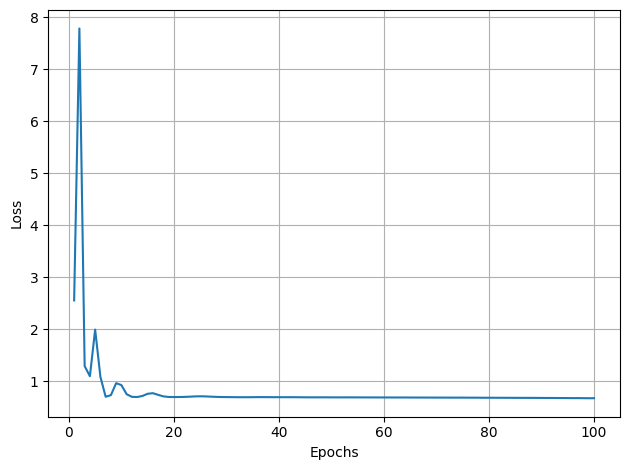

SecoSanMartin


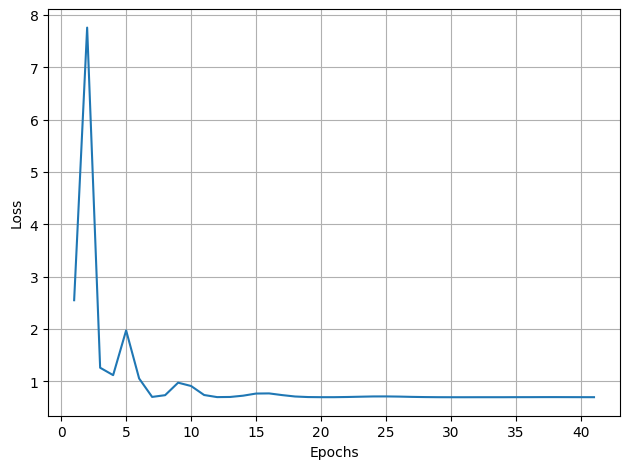

SecoCusco


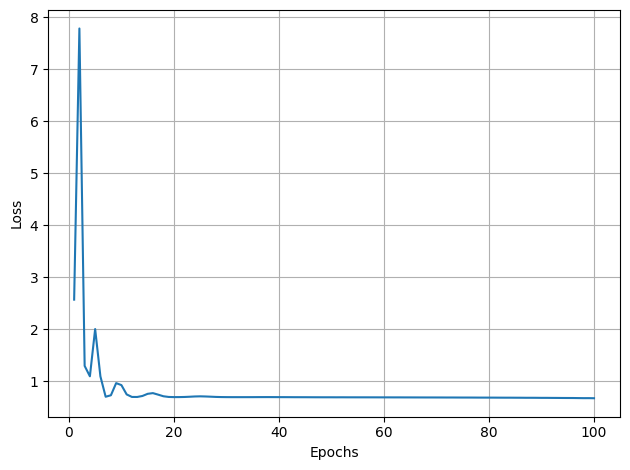

FrescoAmazonas


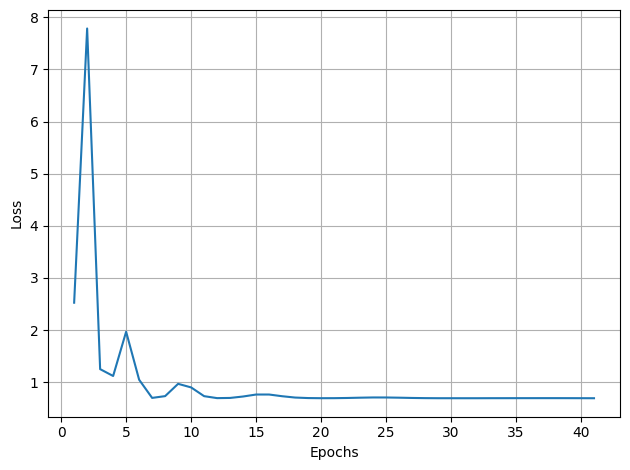

FrescoSanMartin


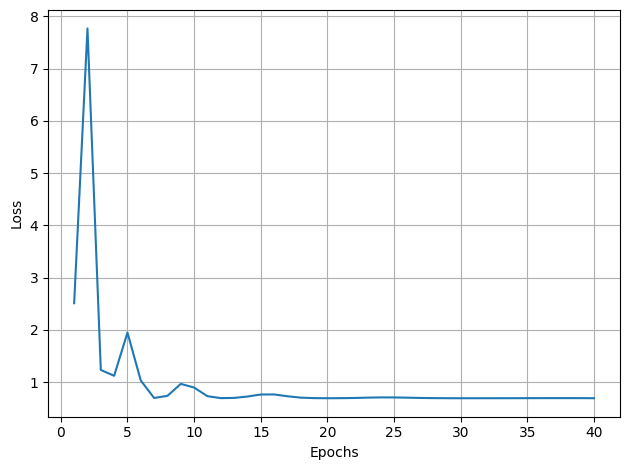

FrescoCusco


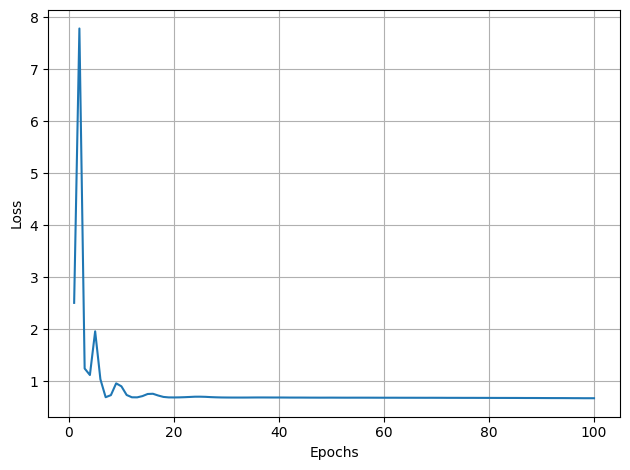

In [20]:
# Loss

for group_id in groups_id:
    print(group_id)
    list_loss = np.load(f"experiments/output/{exp}/loss/{group_id}.npy")

    plt.figure()
    plt.plot(range(1, len(list_loss) + 1), list_loss) #, marker=".")
    # plt.plot(range(1, len(list_loss) + 1), np.log(list_loss)) #, marker=".")
    # plt.title("Training Loss over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid()
    plt.tight_layout()
    # plt.savefig(f"experiments/output/{exp}/plots/loss_{encoder}_{train_set}_{features}.pdf", format="pdf", bbox_inches="tight")
    plt.show()

SecoAmazonas


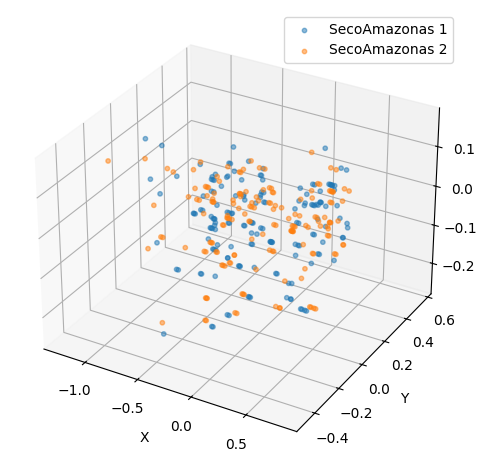

SecoSanMartin


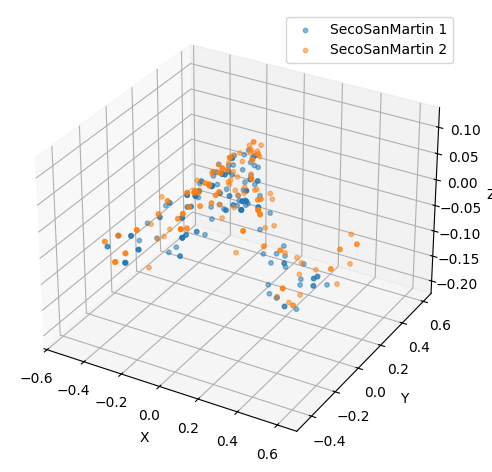

SecoCusco


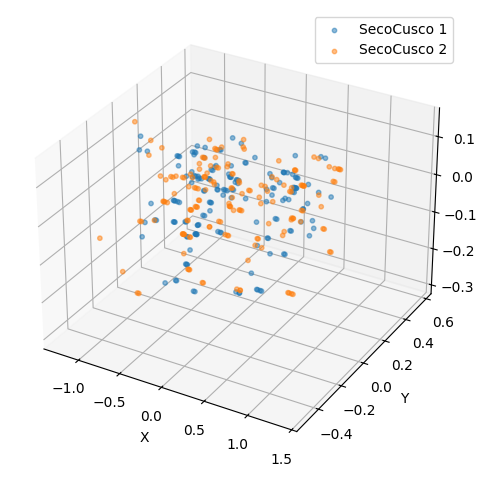

FrescoAmazonas


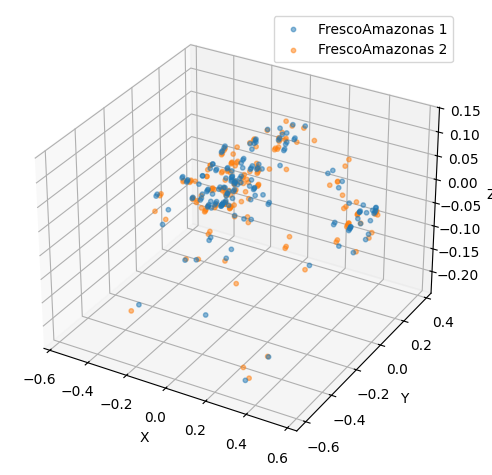

FrescoSanMartin


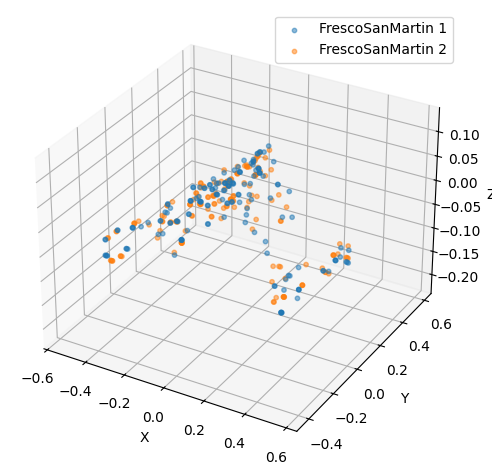

FrescoCusco


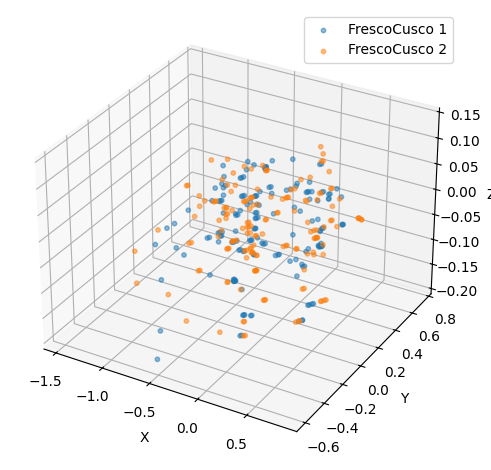

In [21]:
# Node embeddings 3D

for group_id in groups_id:
    print(group_id)

    df_node_embeddings_concat = pd.read_csv(f"experiments/output/{exp}/node_embeddings/{group_id}.csv")
    # Id, 0, 1,	2, ..., subgroup_id

    node_embeddings_concat = df_node_embeddings_concat.iloc[:, 1:-1].values
    labels = df_node_embeddings_concat.iloc[:, -1].values

    if node_embeddings_concat.shape[1] > 3:
        pca = PCA(n_components=3)
        node_embeddings_concat_3d = pca.fit_transform(node_embeddings_concat)
    else:
        node_embeddings_concat_3d = node_embeddings_concat.copy()

    fig = plt.figure()
    ax = fig.add_subplot(projection="3d")

    for c in np.unique(labels):
        ax.scatter(
            node_embeddings_concat_3d[:, 0][labels == c],
            node_embeddings_concat_3d[:, 1][labels == c], 
            node_embeddings_concat_3d[:, 2][labels == c],
            s=10,
            alpha=0.5,
            label=f"{group_id} {c}"
        )

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.legend()
    plt.tight_layout()
    plt.show()

SecoAmazonas


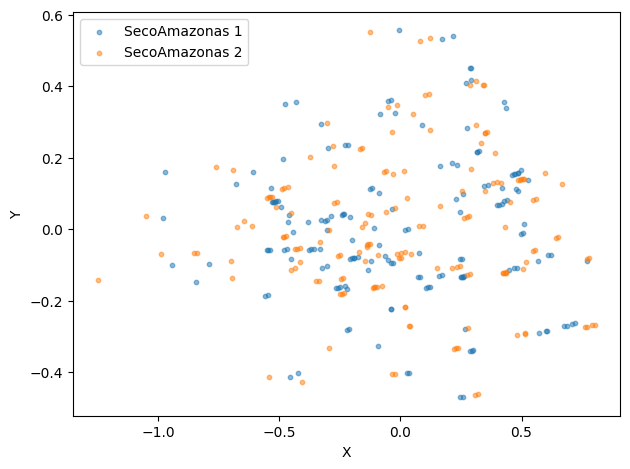

SecoSanMartin


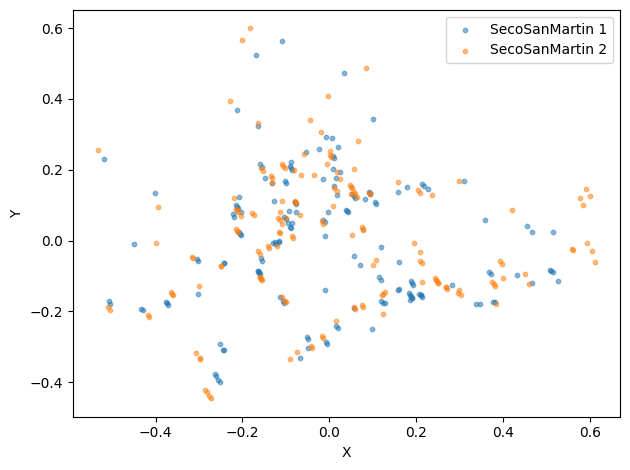

SecoCusco


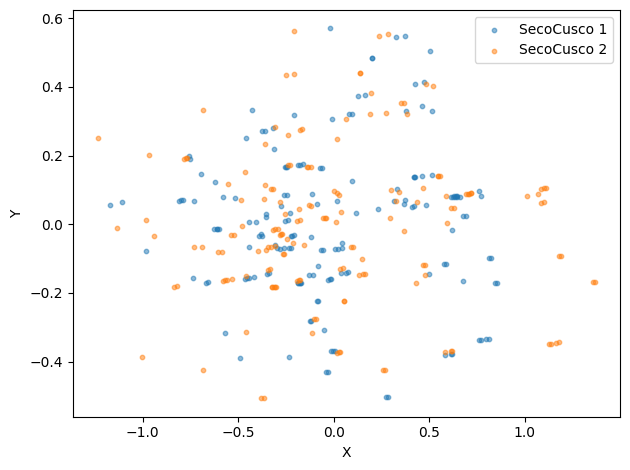

FrescoAmazonas


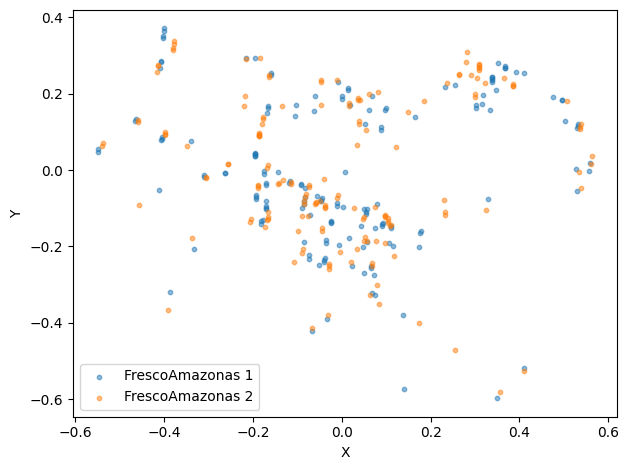

FrescoSanMartin


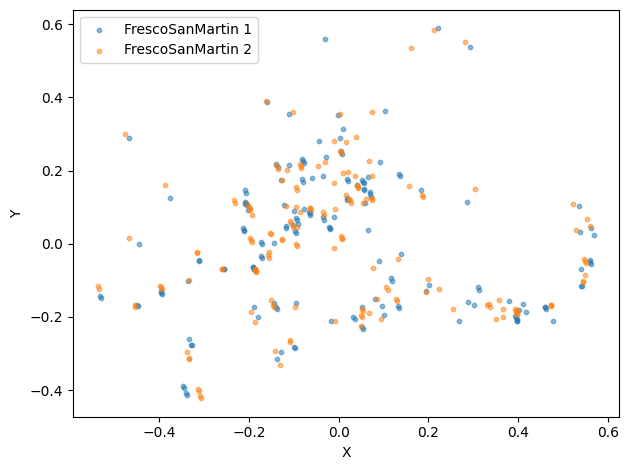

FrescoCusco


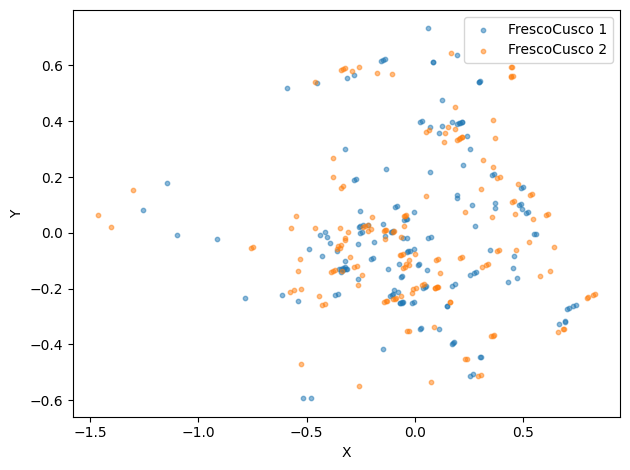

In [22]:
# Node embeddings 2D

for group_id in groups_id:
    print(group_id)

    df_node_embeddings_concat = pd.read_csv(f"experiments/output/{exp}/node_embeddings/{group_id}.csv")
    # Id, 0, 1,	2, ..., subgroup_id

    node_embeddings_concat = df_node_embeddings_concat.iloc[:, 1:-1].values
    labels = df_node_embeddings_concat.iloc[:, -1].values

    if node_embeddings_concat.shape[1] > 2:
        pca = PCA(n_components=2)
        node_embeddings_concat_2d = pca.fit_transform(node_embeddings_concat)
    else:
        node_embeddings_concat_2d = node_embeddings_concat.copy()

    fig, ax = plt.subplots()

    for c in np.unique(labels):
        idx = labels == c
        ax.scatter(
            node_embeddings_concat_2d[idx, 0],
            node_embeddings_concat_2d[idx, 1],
            s=10,
            alpha=0.5,
            label=f"{group_id} {c}"
        )

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.legend()
    plt.tight_layout()
    # plt.savefig(f"experiments/output/{exp}/plots/node_embeddings_{encoder}_{train_set}_{features}.pdf", format="pdf", bbox_inches="tight")
    plt.show()

### Similarity analysis (KNN)

In [23]:
k = 1 # Change

for group_id in groups_id:
    print(group_id)
    df_node_embeddings_concat = pd.read_csv(f"experiments/output/{exp}/node_embeddings/{group_id}.csv", dtype={"subgroup_id": "string"})
    # Id, 0, 1,	2, ..., subgroup_id

    subgroups_id_ = subgroups_id[group_id]

    # Calculate distance matrix (KNN)
    knn = NearestNeighbors(n_neighbors=k, metric="euclidean")

    df_node_embeddings = df_node_embeddings_concat[df_node_embeddings_concat["subgroup_id"] == subgroups_id_[0]]
    x = df_node_embeddings.iloc[:, 1:-1].values

    df_node_alignment = pd.DataFrame()
    df_node_alignment[f"{group_id}_{subgroups_id_[0]}"] = df_node_embeddings["Id"].values

    for subgroup_id in subgroups_id_[1:]:
        df_node_embeddings = df_node_embeddings_concat[df_node_embeddings_concat["subgroup_id"] == subgroup_id]
        y = df_node_embeddings.iloc[:, 1:-1].values

        knn.fit(y)
        distances, indices = knn.kneighbors(x)
        indices = indices.squeeze() # (N,)

        df_node_alignment[f"{group_id}_{subgroup_id}"] = df_node_embeddings["Id"].values[indices]
        
        """ df_node_alignment[f"distances"] = distances
        avg_distances = df_node_alignment["distances"].mean()
        df_node_alignment = df_node_alignment[df_node_alignment["distances"] <= avg_distances].iloc[:, :-1]
        df_node_alignment """
    
    # Find node alignment for all datasets
    df_node_alignment_filter = df_node_alignment[df_node_alignment.nunique(axis=1) == 1]
    # print(len(df_node_alignment_filter))
    # display(df_node_alignment_filter)

    # Save common node id
    common_node_id = df_node_alignment_filter.iloc[:, 0].values
    np.save(f"experiments/output/{exp}/common_nodes/{group_id}.npy", np.array(common_node_id))

SecoAmazonas
SecoSanMartin
SecoCusco
FrescoAmazonas
FrescoSanMartin
FrescoCusco


### Filter MS data

In [24]:
# Read raw data

df_join_raw = pd.read_csv(f"experiments/input/{exp}_raw.csv", index_col=0)
df_join_raw

,Average Rt,Average Mz,Metabolite name,SecoAmazonas_1.1,SecoAmazonas_1.2,SecoAmazonas_1.3,SecoAmazonas_1.4,SecoAmazonas_1.5,SecoAmazonas_1.6,SecoAmazonas_1.7,...,FrescoCusco_2.1,FrescoCusco_2.2,FrescoCusco_2.3,FrescoCusco_2.4,FrescoCusco_2.5,FrescoCusco_2.6,FrescoCusco_2.7,FrescoCusco_2.8,FrescoCusco_2.9,FrescoCusco_2.10
0,1.754,167.01318,unknown,5.103953e+06,2.909582e+07,3.125169e+07,6.979984e+06,3.776234e+06,2.863133e+07,4.037123e+06,...,2.395843e+06,2.913494e+07,3.302601e+07,3.377746e+07,3.140705e+07,6.303288e+06,3.595025e+06,4.349662e+06,2.258032e+07,3.733045e+06
1,2.120,152.05702,unknown,1.947976e+06,2.145146e+06,1.889418e+06,2.043896e+06,2.002084e+06,2.116984e+06,2.053832e+06,...,2.495039e+05,4.248775e+05,3.098800e+05,4.248169e+05,3.134635e+05,3.377903e+05,2.913717e+05,4.368063e+05,3.554469e+05,3.579035e+05
2,2.125,257.96816,unknown,1.241109e+07,2.402011e+06,2.862010e+06,4.805923e+06,1.147833e+07,3.211076e+06,5.251354e+06,...,4.211488e+06,4.924348e+06,1.276892e+07,1.232450e+07,5.350160e+06,5.633231e+06,1.039059e+07,4.392647e+06,1.043688e+07,1.775596e+06
3,2.128,207.98572,unknown,5.125119e+06,6.072819e+06,5.915750e+06,5.901283e+06,4.214018e+06,5.256240e+06,3.877822e+06,...,5.189219e+06,5.727825e+06,3.114297e+06,5.452717e+06,4.734047e+06,5.979402e+06,2.882510e+06,3.723966e+06,3.397263e+06,3.551469e+06
4,2.133,217.96001,unknown,1.784870e+06,1.576395e+06,9.802001e+05,9.512830e+05,1.182384e+06,1.346597e+06,9.234772e+05,...,1.272286e+06,1.024954e+06,1.517614e+06,8.155474e+05,2.014949e+06,1.140160e+06,7.593707e+05,1.368852e+06,7.841276e+05,1.466858e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,20.487,501.26053,unknown,9.652101e+06,9.339857e+06,8.303287e+06,7.917266e+06,9.801720e+06,7.625165e+06,7.665150e+06,...,9.051215e+06,8.542325e+06,9.913880e+06,9.160750e+06,7.710649e+06,8.729660e+06,9.116799e+06,8.177064e+06,8.495683e+06,8.957798e+06
158,22.679,520.34109,unknown,5.664656e+05,6.374233e+05,5.713218e+05,6.079746e+05,5.665560e+05,6.461613e+05,6.930972e+05,...,1.709318e+05,1.485333e+05,1.604937e+05,1.600009e+05,1.443984e+05,1.662257e+05,1.359729e+05,1.329163e+05,1.370356e+05,1.316529e+05
159,23.180,200.20136,unknown,2.699444e+08,2.478668e+08,2.219785e+08,2.460163e+08,2.424722e+08,2.472737e+08,2.737747e+08,...,2.799507e+08,2.382866e+08,2.558865e+08,2.500159e+08,2.473742e+08,2.665944e+08,2.692748e+08,3.050697e+08,2.738012e+08,3.155625e+08
160,24.234,496.34082,unknown,2.327616e+06,4.292726e+06,4.003384e+06,2.273507e+06,2.707995e+06,3.499644e+06,2.781154e+06,...,5.690098e+05,8.297168e+05,2.274319e+05,1.101704e+05,2.477596e+05,6.918046e+05,1.834022e+05,6.792450e+05,4.058503e+05,4.682313e+05


In [25]:
# Filter

for group_id in groups_id:
    # Read common node
    common_node_id = np.load(f"experiments/output/{exp}/common_nodes/{group_id}.npy")
    print(f"{group_id}: {len(common_node_id)}/{len(df_join_raw)}")

    # Filter raw data
    df_join_raw_filter = df_join_raw.loc[common_node_id].iloc[:, [0, 1, 2]]
    df_join_raw_filter.to_csv(f"experiments/output/{exp}/filter_raw/{group_id}.csv", sep=";", decimal=",", index_label="Id")
    df_join_raw_filter

SecoAmazonas: 38/162
SecoSanMartin: 68/162
SecoCusco: 28/162
FrescoAmazonas: 76/162
FrescoSanMartin: 91/162
FrescoCusco: 39/162


### Clustering analysis

SecoAmazonas 38


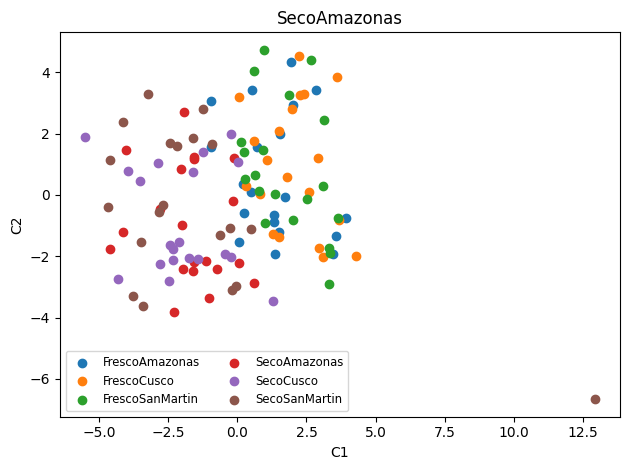

SecoSanMartin 68


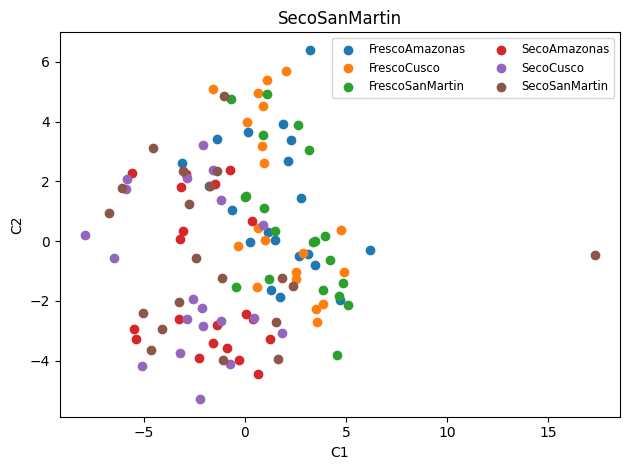

SecoCusco 28


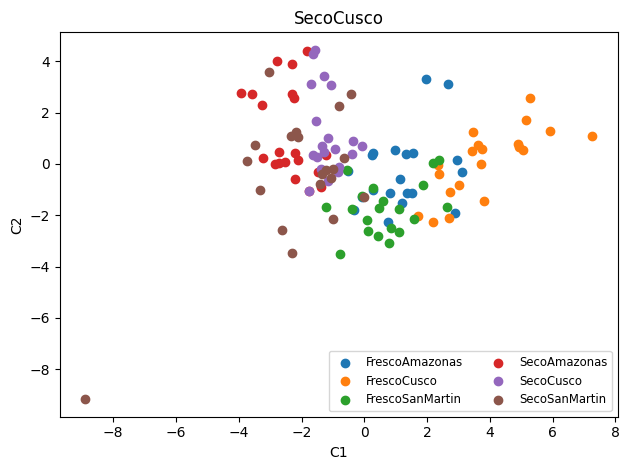

FrescoAmazonas 76


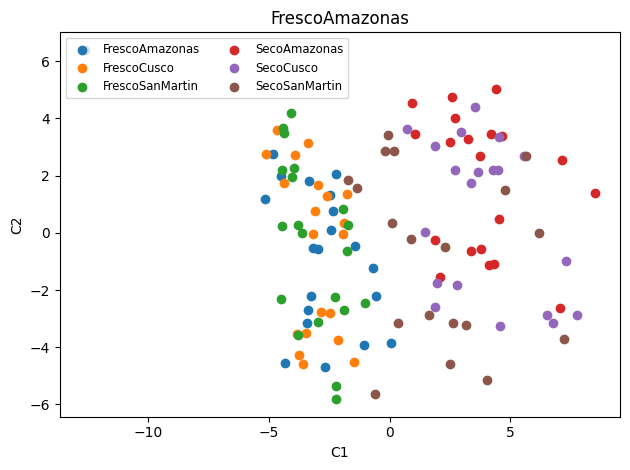

FrescoSanMartin 91


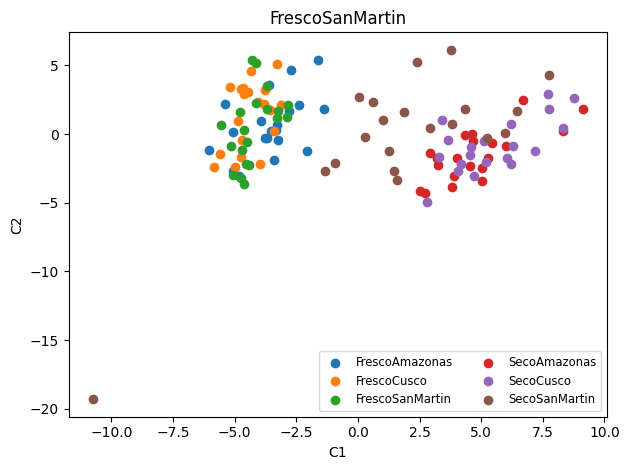

FrescoCusco 39


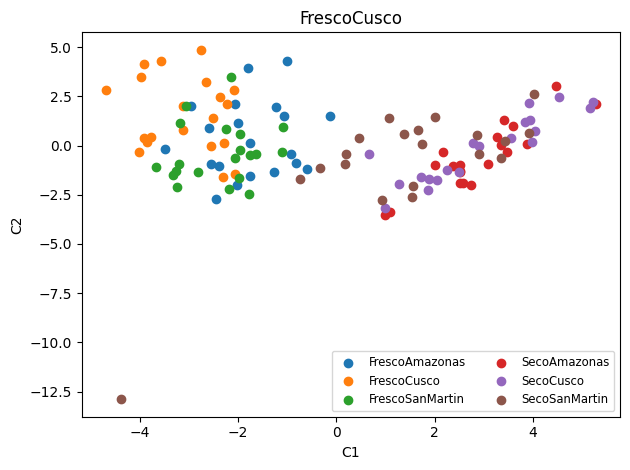

In [26]:
reduction = "PCA" # Change PCA, TSNE, UMAP

for group_id in groups_id:
    # Read common node
    common_node_id = np.load(f"experiments/output/{exp}/common_nodes/{group_id}.npy")
    print(group_id, len(common_node_id))
    
    df_join_raw_signal = df_join_raw.loc[common_node_id].iloc[:, 3:] # Important two last column no only to Mentos 3:-2
    df_join_raw_signal_t = df_join_raw_signal.T
    
    # Scaling
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_join_raw_signal_t.values)

    # Dim. reduction
    if reduction == "TSNE":
        X_reduction = TSNE(n_components=2, learning_rate="auto", init="pca", perplexity=3, random_state=42).fit_transform(X_scaled) # perplexity=5,
    elif reduction == "UMAP" :
        X_reduction = umap.UMAP(n_components=2, random_state=42).fit_transform(X_scaled) # metric="cosine",
    else:
        X_reduction = PCA(n_components=2, random_state=42).fit_transform(X_scaled)
    
    # Plot
    labels = [item.split("_")[0] for item in df_join_raw_signal_t.index]

    x, y = X_reduction[:, 0], X_reduction[:, 1]
    unique_groups = np.unique(labels)

    for group in unique_groups:
        xi = [x[i] for i in range(len(x)) if labels[i] == group]
        yi = [y[i] for i in range(len(y)) if labels[i] == group]
        plt.scatter(xi, yi, label=group)

    plt.legend(fontsize="small", ncol=2)
    plt.xlabel("C1")
    plt.ylabel("C2")
    plt.title(f"{group_id}")
    plt.tight_layout()
    plt.savefig(f"experiments/output/{exp}/plots/clustering_{group_id}.pdf", format="pdf", bbox_inches="tight")
    plt.show()

In [27]:
# import torch
# print(torch.cuda.memory_summary())

In [28]:
# Intersection and Union

list_common_node_id = []
for group_id in groups_id:
    # Read common node
    common_node_id = np.load(f"experiments/output/{exp}/common_nodes/{group_id}.npy")
    list_common_node_id.append(common_node_id)

common_node_id_intersection = list(set.intersection(*map(set, list_common_node_id)))
common_node_id_union = list(set.union(*map(set, list_common_node_id)))

dict_common_node_id_set  = {
    "Intersection": common_node_id_intersection,
    "Union": common_node_id_union
}
print(dict_common_node_id_set)

# Save data
for key, value in dict_common_node_id_set.items():
    # Save common node id
    np.save(f"experiments/output/{exp}/common_nodes/{key}.npy", np.array(value))

    # Save filter raw data
    df_join_raw_filter = df_join_raw.loc[value].iloc[:, [0, 1, 2]]
    df_join_raw_filter.to_csv(f"experiments/output/{exp}/filter_raw/{key}.csv", sep=";", decimal=",", index_label="Id")

{'Intersection': [14], 'Union': [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 29, 30, 33, 35, 36, 38, 39, 40, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 66, 67, 68, 69, 71, 72, 73, 74, 75, 76, 78, 79, 82, 83, 84, 85, 86, 87, 88, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 104, 105, 106, 107, 108, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 138, 139, 140, 141, 142, 143, 144, 145, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161]}


Intersection 1
Error
Union 142


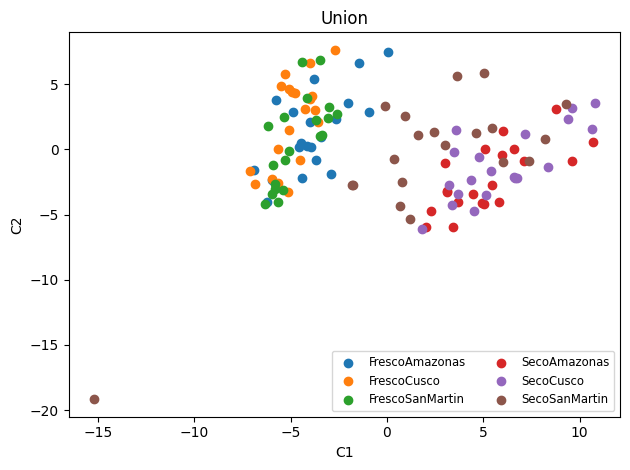

In [29]:
reduction = "PCA" # Change PCA, TSNE, UMAP

for operation, common_node_id_set in dict_common_node_id_set.items():
    print(operation, len(common_node_id_set))
    try:
        df_join_raw_signal = df_join_raw.loc[common_node_id_set].iloc[:, 3:] # Important two last column no only to Mentos 3:-2
        df_join_raw_signal_t = df_join_raw_signal.T

        # Scaling
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(df_join_raw_signal_t.values)

        # Dim. reduction
        if reduction == "TSNE":
            X_reduction = TSNE(n_components=2, learning_rate="auto", init="pca", perplexity=3, random_state=42).fit_transform(X_scaled) # perplexity=5,
        elif reduction == "UMAP" :
            X_reduction = umap.UMAP(n_components=2, random_state=42).fit_transform(X_scaled) # metric="cosine",
        else:
            X_reduction = PCA(n_components=2, random_state=42).fit_transform(X_scaled)

        # Plot
        labels = [item.split("_")[0] for item in df_join_raw_signal_t.index]

        x, y = X_reduction[:, 0], X_reduction[:, 1]
        unique_groups = np.unique(labels)

        plt.figure()

        for group in unique_groups:
            xi = [x[i] for i in range(len(x)) if labels[i] == group]
            yi = [y[i] for i in range(len(y)) if labels[i] == group]
            plt.scatter(xi, yi, label=group)

        plt.legend(fontsize="small", ncol=2)
        plt.xlabel("C1")
        plt.ylabel("C2")
        plt.title(f"{operation}")
        plt.tight_layout()
        plt.savefig(f"experiments/output/{exp}/plots/clustering_{operation}.pdf", format="pdf", bbox_inches="tight")
        plt.show()
    except:
        print("Error")